<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Cecilie/AML_IceCores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [6]:
x_train.shape

(10000, 128, 128)

In [7]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 22s 31ms/step - loss: 0.0293 - val_loss: 0.0114
Epoch 2/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 3/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 4/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 6/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 7/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/200
282/282 [==============================] - 8s 29ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/200
282/282 [==============================] - 8s 29ms/step - loss: 0.00

In [9]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [10]:
y_preds = encoder.predict(x_train)

In [11]:
map = umap.UMAP(n_components=2)
y = map.fit_transform(y_preds)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


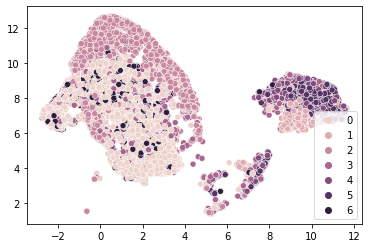

In [12]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [13]:
input_length = len(x_train_feats[0]) + latent_dim

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

dense_model = keras.Model(dense_input, dense_output, name='dense_model')

dense_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

dense_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               12672     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  dense_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 3s 5ms/step - loss: 0.9902 - accuracy: 0.6666 - val_loss: 0.6247 - val_accuracy: 0.7850
Epoch 2/200
282/282 [==============================] - 1s 5ms/step - loss: 0.7253 - accuracy: 0.7472 - val_loss: 0.5849 - val_accuracy: 0.7860
Epoch 3/200
282/282 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.7741 - val_loss: 0.5257 - val_accuracy: 0.8310
Epoch 4/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5892 - accuracy: 0.7949 - val_loss: 0.5101 - val_accuracy: 0.8150
Epoch 5/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5674 - accuracy: 0.7961 - val_loss: 0.5134 - val_accuracy: 0.8080
Epoch 6/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5365 - accuracy: 0.8048 - val_loss: 0.5028 - val_accuracy: 0.8220
Epoch 7/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5225 - accuracy: 0.8104 - val_loss: 0.4928 - val_accuracy: 0.8220

In [39]:
#input_length = len(x_train_feats[0])
input_length = len(y_preds[0])
#input_length = len(x_train_feats[0]) + len(y_preds[0])

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_middle = keras.layers.Dense(128, activation='relu')(x)

nn_last_hidden = keras.Model(dense_input, dense_middle, name='nn_last_hidden')

dense_new_input = keras.layers.InputLayer(input_shape=128)(dense_middle)
x = keras.layers.Dropout(0.2)(dense_new_input)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

nn_model = keras.Model(dense_input, dense_output, name='dense_model')

nn_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

nn_last_hidden.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
nn_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

#nn_model.fit(x_train_feats, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])
nn_model.fit(y_preds, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])
#nn_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_46 (Dense)            (None, 128)               8320      
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_33 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_47 (Dense)            (None, 256)               33024     
                                                                 
 dropout_34 (Dropout)        (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


282/282 [==============================] - 4s 7ms/step - loss: 1.1479 - accuracy: 0.6184 - val_loss: 0.7161 - val_accuracy: 0.7600
Epoch 2/200
282/282 [==============================] - 2s 6ms/step - loss: 0.8239 - accuracy: 0.7193 - val_loss: 0.6460 - val_accuracy: 0.7720
Epoch 3/200
282/282 [==============================] - 2s 7ms/step - loss: 0.7461 - accuracy: 0.7357 - val_loss: 0.6222 - val_accuracy: 0.7850
Epoch 4/200
282/282 [==============================] - 2s 7ms/step - loss: 0.6901 - accuracy: 0.7489 - val_loss: 0.6262 - val_accuracy: 0.7800
Epoch 5/200
282/282 [==============================] - 2s 7ms/step - loss: 0.6644 - accuracy: 0.7588 - val_loss: 0.5890 - val_accuracy: 0.7950
Epoch 6/200
282/282 [==============================] - 2s 7ms/step - loss: 0.6344 - accuracy: 0.7720 - val_loss: 0.5901 - val_accuracy: 0.7830
Epoch 7/200
282/282 [==============================] - 2s 6ms/step - loss: 0.6148 - accuracy: 0.7744 - val_loss: 0.5798 - val_accuracy: 0.7910
Epoch 8/200

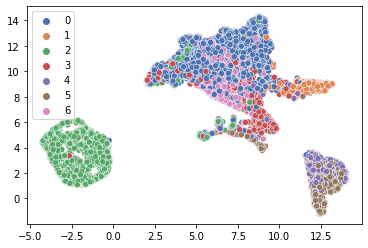

In [40]:
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

#last_hidden_vals = nn_last_hidden.predict(x_train_feats) #x_train_feats[i], y_preds[i], x_train_with_encoded
last_hidden_vals = nn_last_hidden.predict(y_preds)
#last_hidden_vals = nn_last_hidden.predict(x_train_with_encoded)


map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.05)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_only_ims.png')

In [ ]:
len(last_hidden_vals)

In [ ]:
dense_model.save('dense_model')

In [ ]:
tree = lgb.LGBMClassifier(objective='multiclass')

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
y_pred = tree.predict(x_train_with_encoded)

In [ ]:
sum(y_pred==x_train_lab)/len(y_pred)

In [ ]:
input_length = len(x_train_feats[0]) + latent_dim

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_middle = keras.layers.Dense(128, activation='relu')(x)

nn_last_hidden = keras.Model(dense_input, dense_middle, name='nn_last_hidden')

dense_new_input = keras.layers.InputLayer(input_shape=128)(dense_middle)
x = keras.layers.Dropout(0.2)(dense_new_input)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

nn_model = keras.Model(dense_new_input, dense_output, name='dense_model')

nn_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

nn_last_hidden.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
nn_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

nn_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])
